In [24]:
#Download sample from sklearn.datasets
from sklearn.datasets import make_circles

N_SAMPLES = 1000
RANDOM_STATE=42
X,y = make_circles(N_SAMPLES, 
                   noise=0.03, 
                   random_state=RANDOM_STATE)

In [25]:
print(f"First 5: {X[:5]} Labels: {y[:5]}")

First 5: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] Labels: [1 1 1 1 0]


In [26]:
#create dataframes so visualtion is easier
import pandas as pd

circles = pd.DataFrame({"Feature1":X[:,0],
                         "Feature2":X[:,1],
                         "Label": y})
circles.head(10)


,Feature1,Feature2,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [27]:
#check id dataset is balanced or not i.e equal number of labels [1:500, 0: 500]
circles.Label.value_counts()

1    500
0    500
Name: Label, dtype: int64

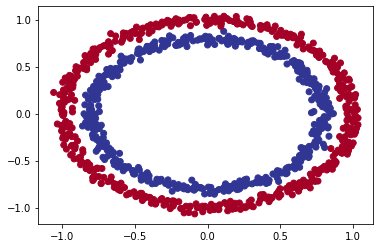

In [28]:
#let plot database to Visualize proper
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [29]:
#convert numpy dataset to tensor
import torch
X =torch.from_numpy(X).type(torch.float)
y =torch.from_numpy(y).type(torch.float)

X[:2], y[:2]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533]]), tensor([1., 1.]))

In [30]:
#Test split dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, #split by 20% [20% test, 80% train ]
                                                    random_state=RANDOM_STATE)

In [31]:
#Device agnositic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [32]:
#create model
from torch import nn

class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10) #as we have 2 features from dataset we are setting in_features=2
    self.layer2 = nn.Linear(in_features=10, out_features=10) #layer1 out_feature=10 so layer2 in_features=10
    self.layer3 = nn.Linear(in_features=10, out_features=1) # label or y is 1 o/p .i.e [0,1]
    self.relu = nn.ReLU() #As it is not linear model it is non linear model
    #as we are using loss function "nn.BCEWithLogitsLoss()" 
    #so we don't have to add sigmoid this loss function automatically add sigmod function

  def forward(self,x):
    #adding reLU activation between each layers
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))



In [33]:
model = CircleModel().to(device) #as we are doing device agnostic code we are adding everything to device[cpu/gpu]
model

CircleModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [34]:
#setting up loss function and optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [38]:
import numpy as np
# Helper Functions
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.
    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.
    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

Lets start with training, below are some of steps

1.   Forward pass
2.   Calculate the loss
3.   Zero gradients
4.   Perform backpropagation on the loss 
5.   Step the optimizer (gradient descent) 
6.   Do Testing on testing set



In [36]:
torch.manual_seed(RANDOM_STATE)
epochs=1200

#Add all variable to device for training
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  #1.Forward pass
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logists is raw o/p from model we need to convert it to predection probs -> predection label

  #2.Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train) #compare loss with predection logits == y_train
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  #3.Optimizer Zero gradient
  optimizer.zero_grad()

  #4.Backpropagation
  loss.backward()

  #5.Optimizer Step
  optimizer.step()

  #Testing
  model.eval() #remove unwanted thing required for inteference
  with torch.inference_mode():
    #forward pass
    y_test_logits = model(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))

    #calculate loss
    test_loss = loss_fn(y_test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,
                            y_pred=y_test_pred)
    
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | loss: {loss:.5f}, Accuracy: {acc:.2f} | test_loss: {test_loss:.5f}%, test_Accuracy: {test_acc:.2f}%")
    


Epoch: 0 | loss: 0.69295, Accuracy: 50.00 | test_loss: 0.69319%, test_Accuracy: 50.00%
Epoch: 100 | loss: 0.69115, Accuracy: 52.88 | test_loss: 0.69102%, test_Accuracy: 52.50%
Epoch: 200 | loss: 0.68977, Accuracy: 53.37 | test_loss: 0.68940%, test_Accuracy: 55.00%
Epoch: 300 | loss: 0.68795, Accuracy: 53.00 | test_loss: 0.68723%, test_Accuracy: 56.00%
Epoch: 400 | loss: 0.68517, Accuracy: 52.75 | test_loss: 0.68411%, test_Accuracy: 56.50%
Epoch: 500 | loss: 0.68102, Accuracy: 52.75 | test_loss: 0.67941%, test_Accuracy: 56.50%
Epoch: 600 | loss: 0.67515, Accuracy: 54.50 | test_loss: 0.67285%, test_Accuracy: 56.00%
Epoch: 700 | loss: 0.66659, Accuracy: 58.38 | test_loss: 0.66322%, test_Accuracy: 59.00%
Epoch: 800 | loss: 0.65160, Accuracy: 64.00 | test_loss: 0.64757%, test_Accuracy: 67.50%
Epoch: 900 | loss: 0.62362, Accuracy: 74.00 | test_loss: 0.62145%, test_Accuracy: 79.00%
Epoch: 1000 | loss: 0.56818, Accuracy: 87.75 | test_loss: 0.57378%, test_Accuracy: 86.50%
Epoch: 1100 | loss: 0.

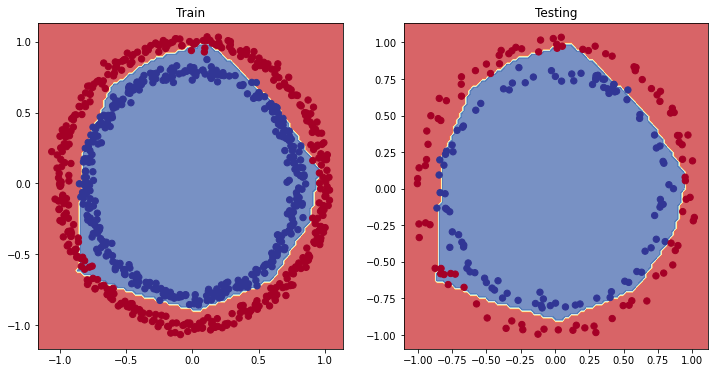

In [39]:
#plot final model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train) # Training set

plt.subplot(1,2,2)
plt.title("Testing")
plot_decision_boundary(model, X_test, y_test) # Test set
